In [40]:
# Cell 1: imports and quick environment check
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import classification_report, confusion_matrix

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


Python: 3.9.23
TensorFlow: 2.20.0
GPU available: []


In [41]:
# Cell 2: load MNIST and prepare data
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load data (downloads automatically if not found)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# OPTION: Use small subset (e.g., 200 train samples) for quick training
USE_SMALL_SUBSET = False   # Change to False to use the full MNIST dataset
if USE_SMALL_SUBSET:
    train_samples = 200
    test_samples = 50
    X_train = X_train[:train_samples]
    y_train = y_train[:train_samples]
    X_test = X_test[:test_samples]
    y_test = y_test[:test_samples]

# Reshape and normalize (so pixel values go from 0–255 → 0–1)
X_train = X_train.reshape(-1,28,28,1).astype('float32') / 255.0
X_test  = X_test.reshape(-1,28,28,1).astype('float32') / 255.0

# Convert labels (0–9) to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


In [42]:
# Cell 3: Data augmentation setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,        # Randomly rotate images by up to 10 degrees
    width_shift_range=0.08,   # Shift horizontally by up to 8%
    height_shift_range=0.08,  # Shift vertically by up to 8%
    zoom_range=0.08           # Random zoom in/out
)

datagen.fit(X_train)
print("✅ Data augmentation setup complete.")


✅ Data augmentation setup complete.


In [43]:
# Cell 4: build CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Sequential model = layer-by-layer stack
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),  # 1st convolution layer
    MaxPooling2D((2,2)),                                          # 1st pooling layer
    Conv2D(64, (3,3), activation='relu'),                         # 2nd convolution layer
    MaxPooling2D((2,2)),                                          # 2nd pooling layer
    Flatten(),                                                    # flatten 2D → 1D
    Dense(128, activation='relu'),                                # fully connected layer
    Dropout(0.4),                                                 # prevent overfitting
    Dense(10, activation='softmax')                               # output layer (10 digits)
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Cell 5: training
epochs = 15   # Increase if using more data
batch_size = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),  # augmented training data
    epochs=epochs,
    validation_data=(X_test, y_test),
    steps_per_epoch=max(1, len(X_train)//batch_size)
)


Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 33ms/step - accuracy: 0.8015 - loss: 0.6047 - val_accuracy: 0.9851 - val_loss: 0.0455
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9512 - loss: 0.1562 - val_accuracy: 0.9882 - val_loss: 0.0328
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9687 - loss: 0.1054 - val_accuracy: 0.9912 - val_loss: 0.0278
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.9740 - loss: 0.0873 - val_accuracy: 0.9888 - val_loss: 0.0317
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9759 - loss: 0.0780 - val_accuracy: 0.9921 - val_loss: 0.0235
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.9774 - loss: 0.0727 - val_accuracy: 0.9922 - val_loss: 0.0212
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9820 - loss: 0.0629 - val_accuracy: 0.9927 - val_loss: 0.0210
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.9840 -

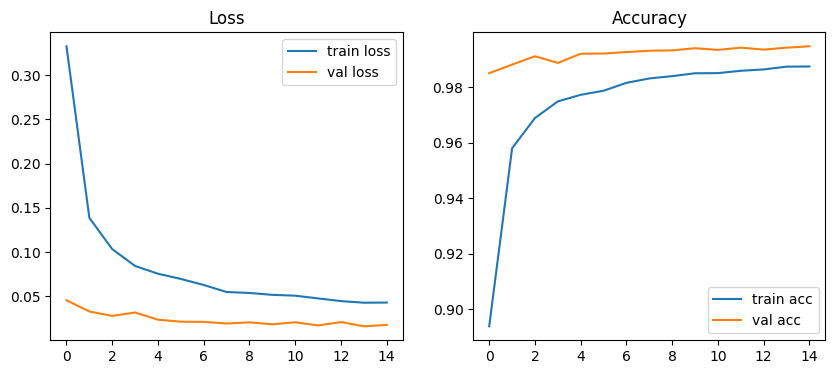

Test loss: 0.0176  Test accuracy: 0.9948


In [45]:
# Cell 6: plot and evaluate
plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.show()

# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}  Test accuracy: {acc:.4f}")


In [46]:
# Cell 7: save model to file
model.save("digit_model.h5")
print("✅ Saved model to digit_model.h5")


✅ Saved model to digit_model.h5


✅ Successfully processed image/1.png
✅ Successfully processed image/2.png
✅ Successfully processed image/3.png
✅ Successfully processed image/4.png
✅ Successfully processed image/5.png
✅ Successfully processed image/6.png
✅ Successfully processed image/7.png
✅ Successfully processed image/8.png
✅ Successfully processed image/9.png

Shape of batch going into model: (9, 28, 28, 1)
This should be (num_images, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


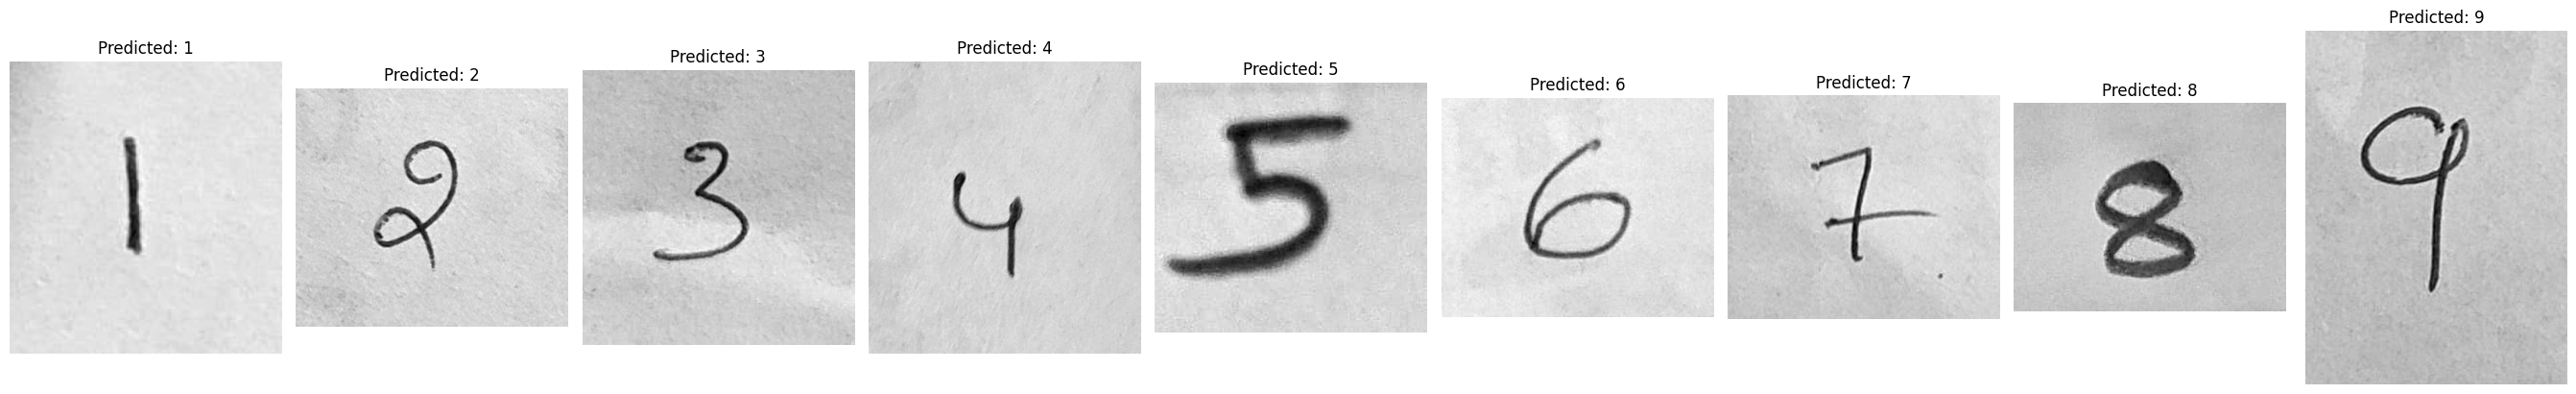

In [56]:
 # Put the filenames of your images here
image_paths = ['image/1.png', 'image/2.png','image/3.png' ,'image/4.png','image/5.png','image/6.png','image/7.png','image/8.png','image/9.png'] #<-- CHANGE THESE

processed_images = []
original_images = []

# Loop through each image path
for path in image_paths:
    try:
        # We re-use the same preprocessing function from before
        processed_img = preprocess_external_image(path)
        processed_images.append(processed_img)
        
        # Also load the original image for displaying later
        original_images.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
        
        print(f"✅ Successfully processed {path}")
    except FileNotFoundError:
        print(f"⚠️ Warning: Image not found at {path}. Skipping.")
    except Exception as e:
        print(f"❌ Error processing {path}: {e}. Skipping.")


# If we have any successfully processed images, predict them
if processed_images:
    # --- THIS IS THE FIX ---
    # More reliable way to stack images into a single batch
    batch = np.concatenate(processed_images, axis=0)
    
    # Let's print the shape to confirm it's correct
    print(f"\nShape of batch going into model: {batch.shape}")
    print("This should be (num_images, 28, 28, 1)")

    # Predict the entire batch in one go
    predictions = model.predict(batch)
    predicted_digits = np.argmax(predictions, axis=1)

    # --- Display the results ---
    num_images = len(predicted_digits)
    plt.figure(figsize=(num_images * 3, 4))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f"Predicted: {predicted_digits[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()